In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directoryµ
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import seaborn as sns

In [ ]:
!pip install pynrrd

In [2]:
import os
from pathlib import Path
# Load dependencies

import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import pickle
import matplotlib.pyplot as plt
import nrrd
#
plt.style.use('default')

In [3]:
import numpy as np
import SimpleITK as sitk


def computeSegmentationMetrics(y_true, y_pred):
    if (y_true > 1).any() or (y_pred > 1).any() or (y_true < 0).any() or (y_pred < 0).any():
        print('WARNING: An input value in segmentation_metrics.py>computeSegmentationMetrics is out of bounds')
    y_true[y_true >= 0.5] = 1
    y_true[y_true  < 0.5] = 0
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred  < 0.5] = 0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    if (y_true == 1).any() or (y_pred == 1).any():
        Hdist, Hmean, Hbmean, H95 = hausdorff(y_true, y_pred, use_contour=False)
        jaccard, dice, similarity, FN, FP = overlapmeasures(y_true, y_pred)
    else:
        Hdist = -1; Hmean = -1; Hbmean = -1; H95 = -1
        jaccard = -1; dice = -1; similarity = -1; FN = -1; FP = -1
    metrics = {}
    metrics['jaccard_coefficient'] = jaccard
    metrics['dice_coefficient']    = dice
    metrics['similarity']          = similarity
    metrics['False_Negative']      = FN
    metrics['False_Positive']      = FP
    metrics['hausdorff_distance']  = Hdist
    metrics['hausdorff_average_distance']          = Hmean
    metrics['hausdorff_balanced_average_distance'] = Hbmean
    metrics['hausdorff_max_distance_at_95']        = H95
    return metrics


def overlapmeasures(ref, candidate):
    """
    Source: http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/34_Segmentation_Evaluation.html
            https://stackoverflow.com/questions/47282895/compute-symmetric-surface-distances-python
    :param ref:
    :param candidate:
    :return:
    """
    numpx_ref = int(np.sum(ref[:]))
    numpx_can = int(np.sum(candidate[:]))
    ref       = sitk.GetImageFromArray(ref)
    candidate = sitk.GetImageFromArray(candidate)
    # Note that for the overlap measures filter, because we are dealing with a single label we
    # use the combined, all labels, evaluation measures without passing a specific label to the methods.
    overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
    overlap_measures_filter.Execute(ref, candidate)
    jaccard    = overlap_measures_filter.GetJaccardCoefficient()
    dice       = overlap_measures_filter.GetDiceCoefficient()
    similarity = overlap_measures_filter.GetVolumeSimilarity()
    if numpx_ref == 0:
        FP = -1
    else:
        FP = overlap_measures_filter.GetFalsePositiveError()
    if numpx_can == 0:
        FN = -1
    else:
        FN = overlap_measures_filter.GetFalseNegativeError()
    return jaccard, dice, similarity, FN, FP


def hausdorff(ref, candidate, use_contour=False):
    """
    Compute the haussdorf distance and related metrics between two masks (2D or 3D)
    Source: http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/34_Segmentation_Evaluation.html
            https://stackoverflow.com/questions/47282895/compute-symmetric-surface-distances-python
    :param ref: (n x m) numpy matrix, reference segmentation's mask, contains only integers {0, 1}
    :param candidate: (n x m) numpy matrix, candidate segmentation's mask, contains only integers {0, 1}
    :param use_contour: boolean, compute the distance using only the contour or not
    :return: hausdorff_distance, hausdorff_mean, hausdorff_bmean, hausdorff_95im
    """
    numpx_ref = int(np.sum(ref[:]))
    numpx_can = int(np.sum(candidate[:]))
    if numpx_ref != 0 and numpx_can != 0:
        ref = sitk.GetImageFromArray(ref)
        candidate = sitk.GetImageFromArray(candidate)
        # Compute the evaluation criteria
        # Note that for the overlap measures filter, because we are dealing with a single label we
        # use the combined, all labels, evaluation measures without passing a specific label to the methods.
        hausdorff_distance_filter = sitk.HausdorffDistanceImageFilter()
        # Use the absolute values of the distance map to compute the surface distances (distance map sign, outside or inside
        # relationship, is irrelevant)
        if use_contour:
            reference_distance_map = sitk.Abs(
                sitk.SignedMaurerDistanceMap(ref, squaredDistance=False, useImageSpacing=True))
        else:
            reference_distance_map = sitk.SignedMaurerDistanceMap(ref, squaredDistance=False, useImageSpacing=True)
            reference_distance_map = np.array(sitk.GetArrayViewFromImage(reference_distance_map))
            reference_distance_map[reference_distance_map <= 0] = 0.
            reference_distance_map = sitk.GetImageFromArray(reference_distance_map)
        #
        reference_surface = sitk.LabelContour(ref) if use_contour else ref
        statistics_image_filter = sitk.StatisticsImageFilter()
        # Get the number of pixels in the reference surface by counting all pixels that are 1.
        statistics_image_filter.Execute(reference_surface)
        num_reference_surface_pixels = int(statistics_image_filter.GetSum())
        # Hausdorff distance
        hausdorff_distance_filter.Execute(ref, candidate)
        hausdorff_distance = hausdorff_distance_filter.GetHausdorffDistance()
        # Symmetric surface distance measures
        if use_contour:
            candidate_distance_map = sitk.Abs(
                sitk.SignedMaurerDistanceMap(candidate, squaredDistance=False, useImageSpacing=True))
        else:
            candidate_distance_map = sitk.SignedMaurerDistanceMap(candidate, squaredDistance=False,
                                                                  useImageSpacing=True)
            candidate_distance_map = np.array(sitk.GetArrayViewFromImage(candidate_distance_map))
            candidate_distance_map[candidate_distance_map < 0] = 0.
            candidate_distance_map = sitk.GetImageFromArray(candidate_distance_map)
        #
        candidate_surface = sitk.LabelContour(candidate) if use_contour else candidate
        # Get the number of pixels in the reference surface by counting all pixels that are 1.
        statistics_image_filter.Execute(candidate_surface)
        num_candidate_surface_pixels = int(statistics_image_filter.GetSum())
        # Multiply the binary surface segmentations with the distance maps. The resulting distance
        # maps contain non-zero values only on the surface (they can also contain zero on the surface)
        can2ref_distance_map = reference_distance_map * sitk.Cast(candidate_surface, sitk.sitkFloat32)
        ref2can_distance_map = candidate_distance_map * sitk.Cast(reference_surface, sitk.sitkFloat32)
        # Get all non-zero distances and then add zero distances if required.
        can2ref_distance_map_arr = sitk.GetArrayViewFromImage(can2ref_distance_map)
        can2ref_distances = list(can2ref_distance_map_arr[can2ref_distance_map_arr != 0])
        ref2can_distance_map_arr = sitk.GetArrayViewFromImage(ref2can_distance_map)
        ref2can_distances = list(ref2can_distance_map_arr[ref2can_distance_map_arr != 0])
        all_surface_distances = can2ref_distances + ref2can_distances
        # The maximum of the symmetric surface distances is the Hausdorff distance between the surfaces. In
        # general, it is not equal to the Hausdorff distance between all voxel/pixel points of the two
        # segmentations, though in our case it is. More on this below.
        hausdorff_mean = (np.sum(can2ref_distances) / num_candidate_surface_pixels + np.sum(
            ref2can_distances) / num_reference_surface_pixels) / 2
        if not all_surface_distances:
            hausdorff_95 = 0.
        else:
            hausdorff_95 = np.percentile(all_surface_distances, 95)
        # According to
        # "On The Usage Of Average Hausdorff Distance For Segmentation Performance Assessment : Hidden Bias When Used For Ranking"
        # the mean should be computed as :
        hausdorff_bmean = (np.sum(can2ref_distances) + np.sum(ref2can_distances)) / (num_reference_surface_pixels * 2)
    else:
        if numpx_ref == 0 and numpx_can == 0:
            max_dist = int(-1)
        else:
            shape = np.array(ref.shape)
            max_dist = np.sqrt(np.sum(shape ** 2))
        hausdorff_distance = max_dist
        hausdorff_mean = max_dist
        hausdorff_bmean = max_dist
        hausdorff_95 = max_dist
    return hausdorff_distance, hausdorff_mean, hausdorff_bmean, hausdorff_95
import numpy as np
import os
import matplotlib.pyplot as plt
#
import nrrd
from tqdm import tqdm
#from smt.sampling_methods import LHS


# -------------------------------------------------------------------------------------------------------------------- #
# - # - # - # - # - # - # - # - # - # - # - # - #  PRE_PROCESSING  # - # - # - # - # - # - # - # - # - # - # - # - # - #
# -------------------------------------------------------------------------------------------------------------------- #


def data_scaling(data, normalization=False, centering=False, standardize=False, per_sample=False):
    # https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/
    eps = 1e-6
    if not per_sample:
        if normalization:
            data = (data - data.min()) / (data.max() - data.min() + eps)
        if centering:
            data = data - data.mean()
        if standardize:
            data = (data - data.mean()) / (data.std() + eps)
    else:
        if data.ndim == 3:
            dimaxis = (1, 2)
            if normalization:
                data = (data - data.min(axis=dimaxis)[:, None, None]) / (data.max(axis=dimaxis) - data.min(axis=dimaxis) + eps)[:, None, None]
            if centering:
                data = data - data.mean(axis=dimaxis)[:, None, None]
            if standardize:
                data = (data - data.mean(axis=dimaxis)[:, None, None]) / (data.std(axis=dimaxis)[:, None, None] + eps)
        elif data.ndim == 4:
            dimaxis = (1, 2, 3)
            if normalization:
                data = (data - data.min(axis=dimaxis)[:, None, None, None]) / (data.max(axis=dimaxis) - data.min(axis=dimaxis) + eps)[:, None, None, None]
            if centering:
                data = data - data.mean(axis=dimaxis)[:, None, None, None]
            if standardize:
                data = (data - data.mean(axis=dimaxis)[:, None, None, None]) / (data.std(axis=dimaxis)[:, None, None, None] + eps)
    return data

# -------------------------------------------------------------------------------------------------------------------- #
# - # - # - # - # - # - # - # - # - # - # - # POST-PROCESSING  # - # - # - # - # - # - # - # - # - # - # - # - # - # - #
# -------------------------------------------------------------------------------------------------------------------- #


def test_time_augmentation_segmentation(data, model, patch_size, n_tta=5, n_split=1, regular=False):
    if regular:
        n_tta = (n_tta - n_tta % 2) + 1
        print('If regular is activated the patches are computed in two rows')
    #
    patch_size = int(patch_size)
    size_data  = data.shape
    # predict the segmentation
    n_patch = np.ceil(np.array(size_data[:2]) / patch_size).astype(np.int)
    lin_ind_x = patch_size*np.array(range(n_patch[0]+1))
    lin_ind_y = patch_size*np.array(range(n_patch[1]+1))
    #
    shift = np.round(patch_size / 2)
    if not regular: sampling = LHS(xlimits=np.array([[-shift, shift], [-shift, shift]]))  # latin hypercube
    aux     = np.zeros(size_data)
    weights = np.zeros(size_data)
    #
    lin_ind = [int(k) for k in np.round(np.linspace(0, n_patch[0]*n_patch[1]*size_data[-1], n_split + 1))]
    for k in tqdm(range(n_split)):
        patch = np.empty(((lin_ind[k+1]-lin_ind[k])*n_tta, patch_size, patch_size, 1))
        Lx_m = []
        Ly_m = []
        Lz_m = []
        L_x = []
        L_y = []
        L_z = []
        cnt = 0
        for i in range(lin_ind[k], lin_ind[k+1]):
            idz = int(i // (n_patch[0]*n_patch[1]))
            idx = int((i % (n_patch[0]*n_patch[1]))  % n_patch[0])
            idy = int((i % (n_patch[0]*n_patch[1])) // n_patch[0])
            if regular:
                ylin = np.linspace(-shift, shift, int((n_tta-1)/2)) if (n_tta-1)/2 >= 2 else 0
                xx, yy = np.meshgrid(np.array([-shift, shift]), ylin)
                xy = np.concatenate((np.reshape(xx, (-1, 1)), np.reshape(yy, (-1, 1))), axis=1)
                sampl_loc = np.concatenate((np.zeros((1, 2)), xy), axis=0)
            else:
                sampl_loc = np.concatenate((np.zeros((1, 2)), np.round(sampling(n_tta-1))), axis=0)
            for j in range(n_tta):
                id_x_bot = int(lin_ind_x[idx] + sampl_loc[j, 0])
                id_x_sup = id_x_bot + patch_size
                id_y_bot = int(lin_ind_y[idy] + sampl_loc[j, 1])
                id_y_sup = id_y_bot + patch_size
                if id_x_bot < size_data[0] and id_x_sup > 0 and id_y_bot < size_data[1] and id_y_sup > 0:
                    # The values on the border are mirrored
                    l0x = np.arange(id_x_bot, id_x_sup).astype(np.int)
                    l_x = np.abs(l0x)
                    l_x[l_x >= size_data[0]] = l_x[l_x >= size_data[0]] - (l_x[l_x >= size_data[0]] % (size_data[0] - 1))
                    l0y = np.arange(id_y_bot, id_y_sup).astype(np.int)
                    l_y = np.abs(l0y)
                    l_y[l_y >= size_data[1]] = l_y[l_y >= size_data[1]] - (l_y[l_y >= size_data[1]] % (size_data[1] - 1))
                    l_x, l_y = np.meshgrid(l_x, l_y)
                    l_x = np.reshape(l_x, -1)
                    l_y = np.reshape(l_y, -1)
                    # Indices for patch of interest
                    f_id_x_bot = int(np.where(l0x >= 0)[0][0])
                    f_id_x_sup = int(np.where(l0x  < size_data[0])[0][-1]) + 1
                    f_id_y_bot = int(np.where(l0y >= 0)[0][0])
                    f_id_y_sup = int(np.where(l0y  < size_data[1])[0][-1]) + 1
                    fl_x, fl_y = np.meshgrid(np.arange(f_id_x_bot, f_id_x_sup), np.arange(f_id_y_bot, f_id_y_sup))
                    fl_x = np.reshape(fl_x, -1); fl_y = np.reshape(fl_y, -1)
                    Lx_m.append(fl_x)
                    Ly_m.append(fl_y)
                    Lz_m.append((cnt*np.ones(len(fl_x))).astype(np.int))
                    #
                    l2_x, l2_y = np.meshgrid(l0x[f_id_x_bot:f_id_x_sup], l0y[f_id_y_bot:f_id_y_sup])
                    l2_x = np.reshape(l2_x, -1)
                    l2_y = np.reshape(l2_y, -1)
                    L_x.append(l2_x)
                    L_y.append(l2_y)
                    L_z.append((idz*np.ones(len(l2_x))).astype(np.int))
                    # Patch extraction
                    patch[cnt, :, :, 0] = np.reshape(data[l_x, l_y, idz], (patch_size, patch_size)).T
                else:
                    patch[cnt, :, :, 0] = np.zeros(patch[cnt, :, :, 0].shape)
                # plt.matshow(patch[cnt, :, :, 0])
                #
                cnt += 1
        Lx_m = np.concatenate(Lx_m); Ly_m = np.concatenate(Ly_m); Lz_m = np.concatenate(Lz_m)
        L_x  = np.concatenate(L_x);  L_y  = np.concatenate(L_y);  L_z  = np.concatenate(L_z)
        # Segmentation
        mask  = model.predict(patch)
        # Attribute weights and values
        for i in range(len(L_x)):
            weights[L_x[i], L_y[i], L_z[i]] += 1
            aux[L_x[i], L_y[i], L_z[i]] += mask[Lz_m[i], Lx_m[i], Ly_m[i], 0]
    data_s = aux / weights
    # export the result
    # data_s = (data_s >= 0.5) * 255.0
    # data_s = data_s * 255.0
    return data_s


# -------------------------------------------------------------------------------------------------------------------- #
# - # - # - # - # - # - # - # - # - # - # FOR ALL  KIND  OF PROCESSING # - # - # - # - # - # - # - # - # - # - # - # - #
# -------------------------------------------------------------------------------------------------------------------- #


def rebuild_from_patches(patches, dim_image, scaling=1, dim=2):
    """
    :param patches: np.array of patches (nb_of_patches, size_patch, size_patch, nb_of_channel)
    :param dim_image: int, dimension in pixels of the target image (not necessarily square)
    :param scaling: factor to scale the data
    :param dim: dimension of the patches
    :return: image, reconstructed stack
    """
    dim_image = np.array(dim_image).astype(np.int)
    if len(dim_image) == 1:
        dim_image = (dim_image, )*dim
    #
    nb_of_patches = patches.shape[0]
    size_patch = patches.shape[1]
    n_patch_per_dim = np.ceil(np.array(dim_image) / size_patch)
    nb_of_channel = int(patches.shape[-1])
    if dim == 2:
        n_slices = nb_of_patches / n_patch_per_dim[0] / n_patch_per_dim[1]
        if n_slices == np.round(n_slices):
            n_slices = int(n_slices)
        else:
            raise ValueError('The number of slices should be an integer')
        image = np.empty([dim_image[0], dim_image[1], n_slices, nb_of_channel], dtype='float32')
        for i_patch in range(nb_of_patches):
            id_z = int(i_patch // (n_patch_per_dim[0] * n_patch_per_dim[1]))
            id_x = (i_patch - id_z * n_patch_per_dim[0] * n_patch_per_dim[1]) % n_patch_per_dim[0]
            id_y = (i_patch - id_z * n_patch_per_dim[0] * n_patch_per_dim[1]) // n_patch_per_dim[0]
            id_x_bot = int(size_patch * id_x)
            id_x_sup = int(np.min((size_patch * (id_x + 1), dim_image[0])))
            id_y_bot = int(size_patch * id_y)
            id_y_sup = int(np.min((size_patch * (id_y + 1), dim_image[1])))
            for i_channel in range(nb_of_channel):
                tmp = patches[i_patch, :, :, i_channel] * scaling
                if tmp.shape[0] != size_patch:
                    tmp = np.concatenate((tmp, np.zeros(size_patch - tmp.shape[0], tmp.shape[1])), axis=0)
                if tmp.shape[1] != size_patch:
                    tmp = np.concatenate((tmp, np.zeros(tmp.shape[0], size_patch - tmp.shape[1])), axis=1)
                image[id_x_bot:id_x_sup, id_y_bot:id_y_sup, id_z, i_channel] = tmp[:id_x_sup - id_x_bot, :id_y_sup - id_y_bot]
    elif dim == 3:
        image = np.empty([dim_image[0], dim_image[1], dim_image[2], nb_of_channel], dtype='float32')
        for i_patch in range(nb_of_patches):
            id_x = int(i_patch % n_patch_per_dim[0])
            id_y = int((i_patch // n_patch_per_dim[0]) % n_patch_per_dim[1])
            id_z = int(i_patch // (n_patch_per_dim[0] * n_patch_per_dim[1]))
            id_x_bot = int(size_patch * id_x)
            id_x_sup = int(np.min((size_patch * (id_x + 1), dim_image[0])))
            id_y_bot = int(size_patch * id_y)
            id_y_sup = int(np.min((size_patch * (id_y + 1), dim_image[1])))
            id_z_bot = int(size_patch * id_z)
            id_z_sup = int(np.min((size_patch * (id_z + 1), dim_image[2])))
            for i_channel in range(nb_of_channel):
                tmp = patches[i_patch, :, :, :, i_channel] * scaling
                if tmp.shape[0] != size_patch:
                    tmp = np.concatenate((tmp, np.zeros(size_patch - tmp.shape[0], tmp.shape[1], tmp.shape[2])), axis=0)
                if tmp.shape[1] != size_patch:
                    tmp = np.concatenate((tmp, np.zeros(tmp.shape[0], size_patch - tmp.shape[1], tmp.shape[2])), axis=1)
                if tmp.shape[2] != size_patch:
                    tmp = np.concatenate((tmp, np.zeros(tmp.shape[0], tmp.shape[1], size_patch - tmp.shape[2])), axis=2)
                image[id_x_bot:id_x_sup, id_y_bot:id_y_sup, id_z_bot:id_z_sup, i_channel] = \
                    tmp[:id_x_sup - id_x_bot, :id_y_sup - id_y_bot, :id_z_sup - id_z_bot]
    return image


def image2patches(patch_size, filepath=None, image=None, factor=1., n_channels=1, dim=2):
    """
    Export the data from the filepath variable
    :param filepath: complete path of the data
    :param image: image (cannot be used with filepath)
    :param patch_size: size of the patches (square)
    :param factor: value weighting the output
    :param n_channels: number of colors channels
    :param dim: dimension of the patches
    :return: numpy array containing the stack from image_path rescaled in [0, 1]
    """
    if filepath is not None:
        if os.path.splitext(filepath)[1] == '.nrrd':
            data_image  = nrrd.read(filepath)[0]
        else:
            raise ImportError('The file must be a nrrd')
    else:
        if image is not None:
            data_image = image
        else:
            raise ValueError('Inputs must contain filepath or stack variable')
    #
    if data_image.min() < 0:
        data_image = data_image - data_image.min()
    data_image = (data_image / data_image.max()) * 255.
    #
    stack_size  = data_image.shape
    num_patch_r = np.ceil(stack_size[0] / patch_size)
    num_patch_c = np.ceil(stack_size[1] / patch_size)
    num_patch_d = np.ceil(stack_size[2] / patch_size) if dim == 3 else stack_size[2]
    nb_patch    = int(num_patch_r * num_patch_c * num_patch_d)
    if dim == 2:
        X = np.empty((nb_patch, patch_size, patch_size, n_channels), dtype='float32')
    elif dim == 3:
        X = np.empty((nb_patch, patch_size, patch_size, patch_size, n_channels), dtype='float32')
    # Generate data
    for i in range(nb_patch):
        # Store sample (values must be in [0, 1])
        if dim == 2:
            X[i, :, :, 0] = get_patch(patch_size, data_image, i) * factor
        elif dim == 3:
            X[i, :, :, :, 0] = get_patch3D(patch_size, data_image, i) * factor
    return X

def get_patch(patch_size, data, i_patch):
    # the patch increment i_patch goes through the rows, then the columns and finally the stacks
    shape_patch_pattern = np.ceil(np.array(data.shape[:2]) / patch_size)
    id_stack = int(i_patch // (shape_patch_pattern[0] * shape_patch_pattern[1]))
    n_col    = int((i_patch - id_stack * (shape_patch_pattern[0] * shape_patch_pattern[1])) // shape_patch_pattern[0])
    id_col   = np.array([n_col, n_col + 1]) * patch_size
    n_row    = int(i_patch - id_stack * (shape_patch_pattern[0] * shape_patch_pattern[1]) - n_col * shape_patch_pattern[0])
    id_row   = np.array([n_row, n_row + 1]) * patch_size
    patch    = data[id_row[0]:min(id_row[1], data.shape[0]), id_col[0]:min(id_col[1], data.shape[1]), id_stack]
    if patch.shape[0] < patch_size:  # I add a stripe of black on the right if necessary
        patch = np.concatenate((patch, np.zeros((patch_size - patch.shape[0], patch.shape[1]))), axis=0)
    if patch.shape[1] < patch_size:  # I add a stripe of black on the bottom if necessary
        patch = np.concatenate((patch, np.zeros((patch.shape[0], patch_size - patch.shape[1]))), axis=1)
    return patch


def get_patch3D(patch_size, data, i_patch):
    # the patch increment i_patch goes through the rows, then the columns and finally the stacks
    shape_patch_pattern = np.ceil(np.array(data.shape) / patch_size)
    n_row  = int(i_patch % shape_patch_pattern[0])
    n_col  = int((i_patch // shape_patch_pattern[0]) % shape_patch_pattern[1])
    n_stk  = int(i_patch // (shape_patch_pattern[0] * shape_patch_pattern[1]))
    id_row = np.array([n_row, n_row + 1]) * patch_size
    id_col = np.array([n_col, n_col + 1]) * patch_size
    id_stk = np.array([n_stk, n_stk + 1]) * patch_size

    patch    = data[id_row[0]:min(id_row[1], data.shape[0]), id_col[0]:min(id_col[1], data.shape[1]), id_stk[0]:min(id_stk[1], data.shape[2])]
    if patch.shape[0] < patch_size:  # I add a stripe of black on the right if necessary
        patch = np.concatenate((patch, np.zeros((patch_size - patch.shape[0], patch.shape[1], patch.shape[2]))), axis=0)
    if patch.shape[1] < patch_size:  # I add a stripe of black on the bottom if necessary
        patch = np.concatenate((patch, np.zeros((patch.shape[0], patch_size - patch.shape[1], patch.shape[2]))), axis=1)
    if patch.shape[2] < patch_size:  # I add a stripe of black on the bottom if necessary
        patch = np.concatenate((patch, np.zeros((patch.shape[0], patch.shape[1], patch_size - patch.shape[2]))), axis=2)
    return patch

In [18]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *


def unet(pretrained_weights=None, input_size=(64, 64, 1), drop_rate=0.0, half_Unet=False, learning_rate=1e-4):
    if half_Unet:
        fact = 2
    else:
        fact = 1
    alpha_ =0.1
    # First half
    inputs = Input(input_size)
    conv1 = Conv2D(64/fact, 3, activation='relu', padding='same',data_format = 'channels_last',groups= 1,use_bias= True, kernel_initializer={'class_name': 'HeNormal', 'config': {'seed': None}},bias_initializer= {'class_name': 'Zeros', 'config': {}})(inputs)
    #conv1 = LeakyReLU(alpha=alpha_)(conv1)
    batch1 = BatchNormalization(axis = 1)(conv1)
    #drop1 = Dropout(drop_rate)(batch1)
    conv1 = Conv2D(128/fact, 3, activation='relu', padding='same', kernel_initializer='he_normal')(batch1)
    #conv1 = LeakyReLU(alpha=alpha_)(conv1)
    batch1 = BatchNormalization(axis = 1)(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(batch1)
    conv2 = Conv2D(128/fact, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    #conv2 = LeakyReLU(alpha=alpha_)(conv2)
    batch2 = BatchNormalization(axis = 1)(conv2)
    drop2 = Dropout(drop_rate)(batch2)
    conv2 = Conv2D(256/fact, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop2)
    #conv2 = LeakyReLU(alpha=alpha_)(conv2)
    batch2 = BatchNormalization(axis = 1)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(batch2)
    conv3 = Conv2D(256/fact, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    #conv3 = LeakyReLU(alpha=alpha_)(conv3)
    batch3 = BatchNormalization(axis = 1)(conv3)
    drop3 = Dropout(drop_rate)(batch3)
    conv3 = Conv2D(512/fact, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop3)
    #conv3 = LeakyReLU(alpha=alpha_)(conv3)
    batch3 = BatchNormalization(axis = 1)(conv3)
    #
    pool3 = MaxPooling2D(pool_size=(2, 2))(batch3)
    conv4 = Conv2D(512/fact, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    #conv4 = LeakyReLU(alpha=alpha_)(conv4)
    batch4 = BatchNormalization(axis = 1)(conv4)
    drop4 = Dropout(drop_rate)(batch4)
    conv4 = Conv2D(1024/fact, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop4)
    #conv4 = LeakyReLU(alpha=alpha_)(conv4)
    batch4 = BatchNormalization(axis = 1)(conv4)
    #
    '''pool4 = MaxPooling2D(pool_size=(5, 5))(batch4)
    conv5 = Conv2D(1024/fact, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    batch5 = BatchNormalization()(conv5)
    drop5 = Dropout(drop_rate)(batch5)
    conv5 = Conv2D(1024/fact, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop5)
    batch5 = BatchNormalization()(conv5)

    # Second half
    
    #up6 = Conv2DTranspose(512/fact, (2, 2), strides=(2, 2), padding='same') (batch5)
    up6    = UpSampling2D(size=(5,5))(batch5)
    merge6 = concatenate([batch4, up6], axis=3)
    conv6  = Conv2D(512/fact, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    batch6 = BatchNormalization()(conv6)
    drop6  = Dropout(drop_rate)(batch6)
    conv6  = Conv2D(512/fact, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop6)
    batch6 = BatchNormalization()(conv6)
    #up7 = Conv2DTranspose(512/fact, (2, 2), strides=(2, 2), padding='same') (batch4)'''
    #
    up7    = UpSampling2D(size=(2, 2))(batch4)
    merge7 = concatenate([batch3, up7], axis=-1)
    conv7  = Conv2D(512/fact, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    #conv7 = LeakyReLU(alpha=alpha_)(conv7)
    batch7 = BatchNormalization(axis = 1)(conv7)
    drop7  = Dropout(drop_rate)(batch7)
    conv7  = Conv2D(512/fact, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop7)
    #conv7 = LeakyReLU(alpha=alpha_)(conv7)
    batch7 = BatchNormalization(axis = 1)(conv7)
    
    up8    = UpSampling2D(size=(2, 2))(batch7)
    merge8 = concatenate([batch2, up8], axis=-1)
    conv8  = Conv2D(256/fact, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    #conv8 = LeakyReLU(alpha=alpha_)(conv8)
    batch8 = BatchNormalization(axis = 1)(conv8)
    drop8  = Dropout(drop_rate)(batch8)
    conv8  = Conv2D(256/fact, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop8)
    #conv8 = LeakyReLU(alpha=alpha_)(conv8)
    batch8 = BatchNormalization(axis = 1)(conv8)
    
    up9    = UpSampling2D(size=(2, 2))(batch8)
    merge9 = concatenate([batch1, up9], axis=-1)
    conv9  = Conv2D(128/fact, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    #conv9 = LeakyReLU(alpha=alpha_)(conv9)
    batch9 = BatchNormalization(axis = 1)(conv9)
    drop9  = Dropout(drop_rate)(batch9)
    conv9  = Conv2D(128/fact, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop9)
    #conv9 = LeakyReLU(alpha=alpha_)(conv9)
    batch9 = BatchNormalization(axis = 1)(conv9)
    #not in the paper
    conv9  = Conv2D(1, 1, activation='linear', padding='same', kernel_initializer='he_normal')(batch9)
    #conv9 = LeakyReLU(alpha=alpha_)(conv9)
    #batch9 = BatchNormalization()(conv9)
    #
    conv10 = tf.keras.activations.sigmoid(conv9)
    #conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    # model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    # model.summary()

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [4]:
# trick from 
# https://stackoverflow.com/questions/53698035/failed-to-get-convolution-algorithm-this-is-probably-because-cudnn-failed-to-in
use_trick = True
if use_trick:
    import tensorflow as tf
    from tensorflow.compat.v1.keras.backend import set_session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
    config.log_device_placement = True  # to log device placement (on which device the operation ran)
    sess = tf.compat.v1.Session(config=config)
    set_session(sess)

Device mapping: no known devices.


In [ ]:
file = tf.io.gfile.glob('../input/first-data')
file_val = tf.io.gfile.glob('../input/first-data')

In [34]:
infile = open('data_pred.pickle','rb')
DATA = pickle.load(infile)
infile.close()

In [103]:
DATA['output'].shape[0]

1736

In [41]:
def rotation_up_down(data_x, data_y):
    data_x_res = np.zeros(data_x.shape)
    data_y_res = np.zeros(data_x.shape)
    for i in range(1736):
        x = tf.image.flip_up_down(data_x[i].reshape((64, 64, 1)))
        y = tf.image.flip_up_down(data_y[i].reshape((64, 64, 1)))
        data_x_res[i] = np.array(x).reshape((1, 64, 64))
        data_y_res[i] = np.array(y).reshape((1, 64, 64))
    return data_x_res, data_y_res

def rotation_left_right(data_x, data_y):
    data_x_res = np.zeros(data_x.shape)
    data_y_res = np.zeros(data_x.shape)
    for i in range(1736):
        x = tf.image.flip_left_right(data_x[i].reshape((64, 64, 1)))
        y = tf.image.flip_left_right(data_y[i].reshape((64, 64, 1)))
        data_x_res[i] = np.array(x).reshape((1, 64, 64))
        data_y_res[i] = np.array(y).reshape((1, 64, 64))
    return data_x_res, data_y_res

def rot90(data_x, data_y):
    data_x_res = np.zeros(data_x.shape)
    data_y_res = np.zeros(data_x.shape)
    for i in range(1736):
        x = tf.image.rot90(data_x[i].reshape((64, 64, 1)))
        y = tf.image.rot90(data_y[i].reshape((64, 64, 1)))
        data_x_res[i] = np.array(x).reshape((1, 64, 64))
        data_y_res[i] = np.array(y).reshape((1, 64, 64))
    return data_x_res, data_y_res


def adjust_brightness(data_x, data_y):
    data_x_res = np.zeros(data_x.shape)
    data_y_res = np.zeros(data_x.shape)
    for i in range(1736):
        x = tf.image.adjust_brightness(data_x[i].reshape((64, 64, 1)),0.4)
        y = tf.image.adjust_brightness(data_y[i].reshape((64, 64, 1)),0.4)
        data_x_res[i] = np.array(x).reshape((1, 64, 64))
        data_y_res[i] = np.array(y).reshape((1, 64, 64))
    return data_x_res, data_y_res

In [42]:
#x_adjust_saturation, y_adjust_saturation = adjust_saturation(DATA['l1_pred'], DATA['input'])

x_adjust_brightness, y_adjust_brightness = adjust_brightness(DATA['l1_pred'], DATA['output'])
x_up_down, y_up_down = rotation_up_down(DATA['l1_pred'], DATA['output'])
x_left_right, y_left_right = rotation_left_right(DATA['l1_pred'], DATA['output'])
x_rot90, y_rot90 = rot90(DATA['l1_pred'], DATA['output'])


In [47]:
X_test =np.concatenate((DATA['l1_pred'], x_up_down,x_adjust_brightness,x_left_right,x_rot90), axis = 0)
y_test =np.concatenate((DATA['output'],  y_up_down,y_adjust_brightness,y_left_right,y_rot90), axis = 0)


In [106]:
X_valid.shape

(868, 1, 64, 64)

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_test, y_test, test_size=0.1, random_state=42)

x,y,z,_ = X_valid.shape
x1,y,z,_ = X_train.shape
data_x_train = X_train.reshape(x1, 64, 64, 1).astype('float32')
data_y_train = y_train.reshape(x1,64, 64, 1).astype('float32')
data_x_valid = X_valid.reshape(x, 64, 64, 1).astype('float32')
data_y_valid =y_valid.reshape(x, 64, 64, 1).astype('float32')

In [ ]:
data_y_train[data_y_train>=255/2] = 255
data_y_train[data_y_train<255/2] = 0
data_x_train = (data_x_train - data_x_train.min())/(data_x_train.max() - data_x_train.min())
data_y_train = (data_y_train - data_y_train.min())/(data_y_train.max() - data_y_train.min())
data_x_valid = (data_x_valid - data_x_valid.min())/(data_x_valid.max() - data_x_valid.min())
data_y_valid = (data_y_valid - data_y_valid.min())/(data_y_valid.max() - data_y_valid.min())

In [ ]:
'''path_common    = Path(file[0])
path_raw_train = Path(path_common / "train_x.nrrd")
path_seg_train = Path(path_common / "train_y.nrrd")
path_common    = Path(file_val[0])
path_raw_valid = Path(path_common / "val_x.nrrd")
path_seg_valid = Path(path_common / "val_y.nrrd")
data_x_train = np.transpose(nrrd.read(path_raw_train)[0][..., np.newaxis], (2, 0, 1, 3)).astype('float32')
data_y_train = np.transpose(nrrd.read(path_seg_train)[0][..., np.newaxis], (2, 0, 1, 3)).astype('float32')
data_x_valid = np.transpose(nrrd.read(path_raw_valid)[0][..., np.newaxis], (2, 0, 1, 3)).astype('float32')
data_y_valid = np.transpose(nrrd.read(path_seg_valid)[0][..., np.newaxis], (2, 0, 1, 3)).astype('float32')
data_y_train[data_y_train>=255/2] = 255
data_y_train[data_y_train<255/2] = 0
data_x_train = (data_x_train - data_x_train.min())/(data_x_train.max() - data_x_train.min())
data_y_train = (data_y_train - data_y_train.min())/(data_y_train.max() - data_y_train.min())
data_x_valid = (data_x_valid - data_x_valid.min())/(data_x_valid.max() - data_x_valid.min())
data_y_valid = (data_y_valid - data_y_valid.min())/(data_y_valid.max() - data_y_valid.min())'''

In [ ]:
import cv2

In [50]:
n_epochs = 10
batch_size = 32
learning_rate = 0.01
drop_rate = 0.00
#
patch_size = 64

In [51]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    dim = len(y_true.shape)
    intersection = K.sum(y_true * y_pred, axis=tuple(np.arange(1, dim)))
    union_s      = K.sum(K.square(y_true) + K.square(y_pred), axis=tuple(np.arange(1, dim)))
    dice         = (2. * intersection + smooth) / (union_s + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1 - K.mean(dice_coef(y_true, y_pred),axis=-1)

In [121]:
dice_coef_loss(data_x_train[0], data_y_train[0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.6402605>

In [52]:
model_sara = unet(input_size=(patch_size, patch_size, 1), drop_rate=drop_rate, half_Unet=True, learning_rate=learning_rate)
model_sara.compile(optimizer=Adam(learning_rate=learning_rate), loss=dice_coef_loss, metrics=[dice_coef])

In [53]:
model_history = model_sara.fit(x=data_x_train, y=data_y_train, validation_data=(data_x_valid, data_y_valid), epochs=n_epochs, batch_size=batch_size)

Epoch 1/10
245/245 [==============================] - 2513s 10s/step - loss: 0.2883 - dice_coef: 0.7117 - val_loss: 0.5160 - val_dice_coef: 0.4840
Epoch 2/10
245/245 [==============================] - 2348s 10s/step - loss: 0.2137 - dice_coef: 0.7863 - val_loss: 0.2137 - val_dice_coef: 0.7863
Epoch 3/10
245/245 [==============================] - 2067s 8s/step - loss: 0.1786 - dice_coef: 0.8214 - val_loss: 0.1675 - val_dice_coef: 0.8325
Epoch 4/10
245/245 [==============================] - 2074s 8s/step - loss: 0.1541 - dice_coef: 0.8459 - val_loss: 0.1694 - val_dice_coef: 0.8306
Epoch 5/10
245/245 [==============================] - 2090s 9s/step - loss: 0.1439 - dice_coef: 0.8561 - val_loss: 0.1800 - val_dice_coef: 0.8200
Epoch 6/10
245/245 [==============================] - 2085s 9s/step - loss: 0.1352 - dice_coef: 0.8648 - val_loss: 0.1258 - val_dice_coef: 0.8742
Epoch 7/10
245/245 [==============================] - 2078s 8s/step - loss: 0.1441 - dice_coef: 0.8559 - val_loss: 0.1386 

In [ ]:

import tensorflow_addons as tfa

In [57]:
model_history.history

{'loss': [0.2882893979549408,
  0.21373382210731506,
  0.178599014878273,
  0.15411002933979034,
  0.1438644826412201,
  0.13522009551525116,
  0.14414465427398682,
  0.1264781504869461,
  0.11953211575746536,
  0.12419699132442474],
 'dice_coef': [0.711711049079895,
  0.7862660884857178,
  0.8214011788368225,
  0.84589022397995,
  0.8561357855796814,
  0.8647796511650085,
  0.8558552861213684,
  0.8735215067863464,
  0.8804678320884705,
  0.8758031129837036],
 'val_loss': [0.5160126090049744,
  0.2136777937412262,
  0.16751617193222046,
  0.16941684484481812,
  0.1800224483013153,
  0.12575015425682068,
  0.13856250047683716,
  0.12015480548143387,
  0.13034626841545105,
  0.11427809298038483],
 'val_dice_coef': [0.483987420797348,
  0.7863221168518066,
  0.8324838280677795,
  0.8305830955505371,
  0.8199775218963623,
  0.8742498159408569,
  0.8614373803138733,
  0.8798452615737915,
  0.8696536421775818,
  0.8857218623161316]}

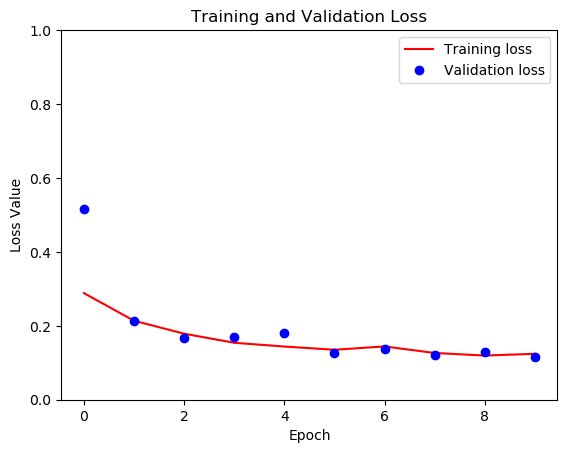

In [54]:
loss     = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochsr  = range(len(model_history.epoch))
# Plot
plt.figure()
plt.plot(epochsr, loss, 'r', label='Training loss')
plt.plot(epochsr, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.savefig('loss.png')
plt.show()

In [66]:
model_sara.save('model_sara')

INFO:tensorflow:Assets written to: model_sara\assets


In [ ]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [ ]:
import tensorflow.keras

In [ ]:
plt.imshow(nrrd.read('C:/Users/hp/Desktop/pfe_sdbd/x/0.nrrd')[0][:,:,0])

In [ ]:
#model_nathan = keras.models.load_model('../input/codefghjklm/model_1_checkpoint', custom_objects={'dice_coef': lambda x: x, 'loss': lambda x: x})

In [55]:
#import keras
import tensorflow as tf
import numpy as np
import pickle
import nrrd
#
#from src.data_process import image2patches, rebuild_from_patches
#from src.segmentation_metrics import computeSegmentationMetrics
#
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)
#listfiles   = Path('../input/lgg-mri-segmentation/null')
pathtestdat = 'C:/Users/hp/Desktop/pfe_sdbd/x/'
pathtestdat_seg = 'C:/Users/hp/Desktop/pfe_sdbd/y/'
listfiles   = os.listdir(pathtestdat)
print('Processing Unet trained on humanized data')
patch_size = 64
metrics_unet_humanization = []
#image = skimage.io.imread('../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif', plugin='tifffile')
#stack = np.uint8(stack*255.0/stack.max())
for file in listfiles:
    if file == '0.nrrd':
        break
    print(file)
    image, header = nrrd.read(pathtestdat + file)
    image_pred = np.zeros(image.shape)
    shifts     = [[0, 0], [patch_size/2, 0], [0, patch_size/2], [patch_size/2, patch_size/2]]
    for (i, shift) in enumerate(shifts):
        print('\tPrediction {}/{}'.format(i+1, len(shifts)))
        sizeloc    = tuple(np.array(image.shape).astype(int) + np.array(shift + [0,]).astype(int))
        imageloc   = np.zeros(sizeloc)
        imageloc[int(shift[0]):, int(shift[1]):, :] = image
        patches    = image2patches(patch_size, filepath=None, image=imageloc, factor=1., n_channels=1, dim=2)
        patches   = (patches - patches.min())/(patches.max() - patches.min()) 
        prediction = model_sara.predict(patches)
        prediction = rebuild_from_patches(prediction, np.array(sizeloc)[0:2], scaling=1, dim=2)
        prediction = np.squeeze(prediction.astype(np.float32))
        if i == 0 and len(prediction.shape) == 4:
            image_pred = np.stack((image_pred,)*prediction.shape[-1], -1)
        image_pred += prediction[int(shift[0]):, int(shift[1]):, :] / len(shifts)

    image_pred[image_pred >= 0.5] = 1
    image_pred[image_pred  < 0.5] = 0#enregistré
    image_seg  = nrrd.read(pathtestdat_seg + file)[0]
    image_seg  = ((image_seg - image_seg.min())/( image_seg.max()-image_seg.min())).astype(np.float32)
    metrics_unet_humanization.append(computeSegmentationMetrics(image_seg, image_pred))
#
#
# save
#

output = {}
output['metrics_unet_humanization'] = metrics_unet_humanization#enregistré
#with open(fold_save + 'performance_measures_unet_humanization', 'wb') as file_pi:
    #pickle.dump(output, file_pi)

Device mapping: no known devices.
Processing Unet trained on humanized data


In [56]:
file = '0.nrrd'
    
print(file)
image, header = nrrd.read(pathtestdat + file)
image_pred = np.zeros(image.shape)
shifts     = [[0, 0], [patch_size/2, 0], [0, patch_size/2], [patch_size/2, patch_size/2]]
for (i, shift) in enumerate(shifts):
    print('\tPrediction {}/{}'.format(i+1, len(shifts)))
    sizeloc    = tuple(np.array(image.shape).astype(int) + np.array(shift + [0,]).astype(int))
    imageloc   = np.zeros(sizeloc)
    imageloc[int(shift[0]):, int(shift[1]):, :] = image
    patches    = image2patches(patch_size, filepath=None, image=imageloc, factor=1., n_channels=1, dim=2)
    patches   = (patches - patches.min())/(patches.max() - patches.min()) 
    prediction = model_sara.predict(patches)
    prediction = rebuild_from_patches(prediction, np.array(sizeloc)[0:2], scaling=1, dim=2)
    prediction = np.squeeze(prediction.astype(np.float32))
    if i == 0 and len(prediction.shape) == 4:
        image_pred = np.stack((image_pred,)*prediction.shape[-1], -1)
    image_pred += prediction[int(shift[0]):, int(shift[1]):, :] / len(shifts)

image_pred[image_pred >= 0.5] = 1
image_pred[image_pred  < 0.5] = 0#enregistré
image_seg  = nrrd.read(pathtestdat_seg + file)[0]
image_seg  = ((image_seg - image_seg.min())/( image_seg.max()-image_seg.min())).astype(np.float32)
metrics_unet_humanization.append(computeSegmentationMetrics(image_seg, image_pred))
#
#
# save
#

output = {}
output['metrics_unet_humanization'] = metrics_unet_humanization#enregistré
#with open(fold_save + 'performance_measures_unet_humanization', 'wb') as file_pi:
#pickle.dump(output, file_pi)

0.nrrd
	Prediction 1/4
	Prediction 2/4
	Prediction 3/4
	Prediction 4/4


In [96]:
import numpy as np
import napari
from skimage import data, filters  # Just to generate some test data (3D blobs).

with napari.gui_qt():

    # Generate some test data (smooth 3D blob shapes)
    imgarray = filters.gaussian(np.squeeze(np.stack([data.binary_blobs(length=300, n_dim=3, blob_size_fraction=0.1, volume_fraction=0.05)[:, 0:256, 0:256]])).astype(float), sigma=(2.5, 2.5, 2.5))
    print(imgarray.shape)

    '''
    # If imgarray values are bytes (0..255), convert to floats for display.
    imgarray = imgarray.astype(float) / 255
    '''

    # Open viewer (Qt window) with axes = slice, row, column
    viewer = napari.Viewer(title='volume test', ndisplay=3, order=(0, 1, 2))
    viewer.add_image(data=imgarray, name='blobs', scale=[256/300, 1, 1], colormap='gray_trans', rendering='attenuated_mip', attenuation=2.0, contrast_limits=(0.25, 1))


C:\ProgramData\Anaconda3\lib\site-packages\napari\_qt\qt_event_loop.py:256: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  warn(


(300, 256, 256)
---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
C:\ProgramData\Anaconda3\lib\site-packages\napari\utils\colormaps\colormap_utils.py in vispy_or_mpl_colormap(name='gray_trans')
    392         try:
--> 393             mpl_cmap = getattr(cm, name)
        mpl_cmap = undefined
        global getattr = undefined
        global cm = <module 'napari.utils.colormaps.vendored.cm' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\napari\\utils\\colormaps\\vendored\\cm.py'>
        name = 'gray_trans'
    394             if name in _MATPLOTLIB_COLORMAP_NAMES:

AttributeError: module 'napari.utils.colormaps.vendored.cm' has no attribute 'gray_trans'

During handling of the above exception, another exception occurred:

KeyError                                  Traceback (most recent call last)
C:\ProgramData\Anaconda3\lib\site-packages\napari\_qt\qt_event_loop.py in gui_qt(st

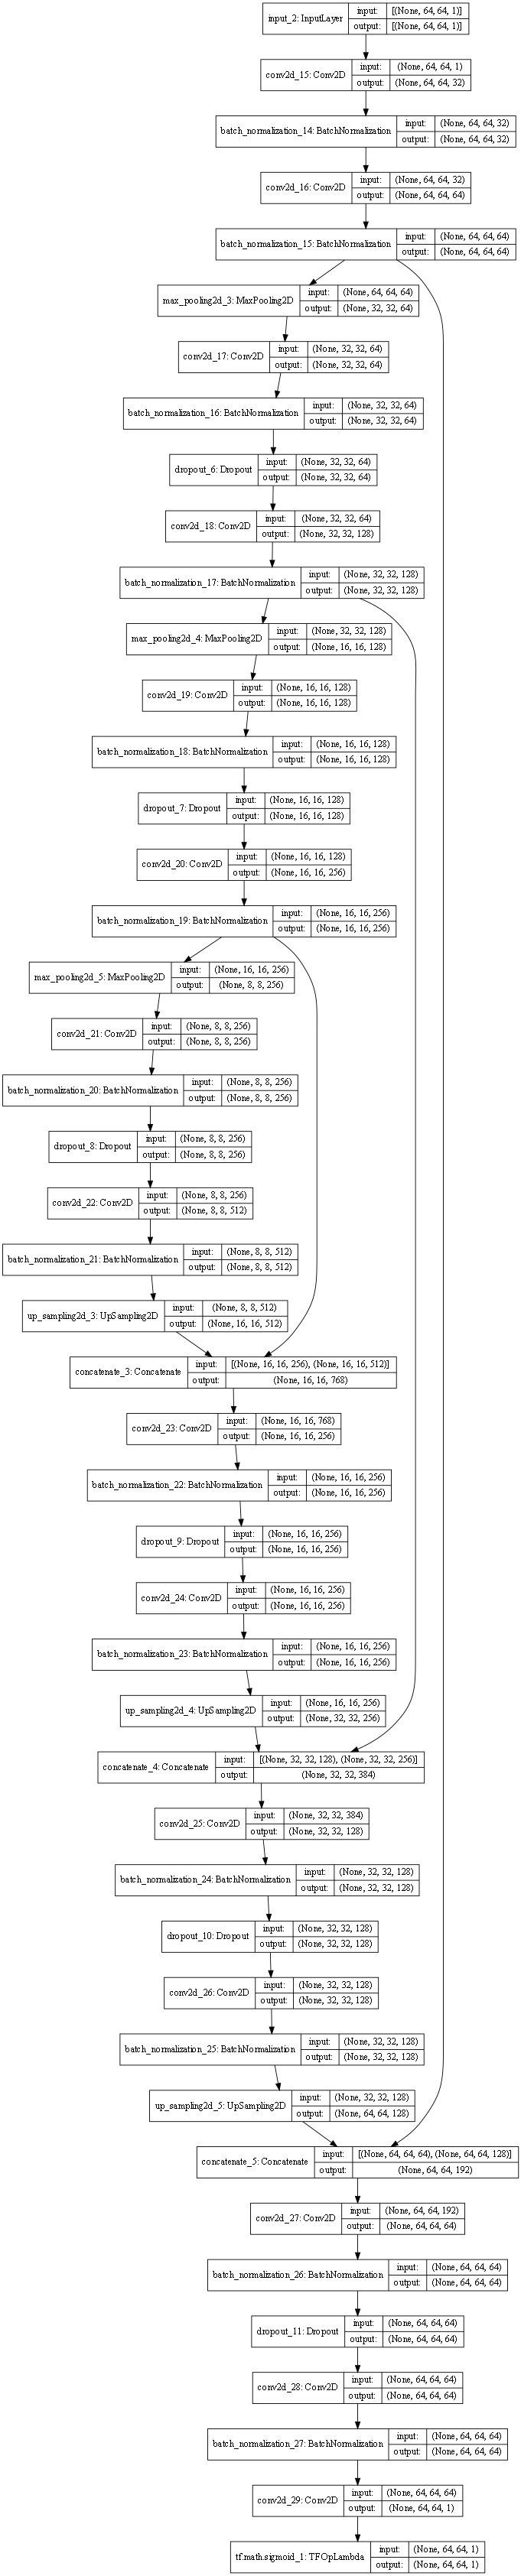

In [104]:

tf.keras.utils.plot_model(model_sara, show_shapes=True, dpi=64, to_file='model_sara.png')

In [59]:
import json
json = json.dumps(output)
f = open("dict_res.json","w")
f.write(json)
f.close()

In [60]:
x = output['metrics_unet_humanization']

In [71]:
import numpy as np
import nrrd

filename = 'image_pred.nrrd'
nrrd.write(filename, image_pred)


In [120]:
output

{'metrics_unet_humanization': [{'jaccard_coefficient': 0.6343091394023972,
   'dice_coefficient': 0.7762413170305579,
   'similarity': 0.4090131540140388,
   'False_Negative': 0.024201464658234643,
   'False_Positive': 0.35555244624784293,
   'hausdorff_distance': 112.96459622377269,
   'hausdorff_average_distance': 1.0247510248626277,
   'hausdorff_balanced_average_distance': 0.9809751177650297,
   'hausdorff_max_distance_at_95': 19.94993782043457}]}

In [118]:
str_ = 'hausdorff_average_distance'
for i in range(1):
    table[i] = x[i][str_]
data_1 = pd.DataFrame(columns=['valeur','metric'])
data_1['valeur'] = table
data_1['metric'] = str_
ax = sns.boxplot(x='metric',y='valeur',data=data_1)
plt.savefig(str_+'.png')
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
str_ = 'hausdorff_max_distance_at_95'
for i in range(15):
    table[i] = x[i][str_]
data_1 = pd.DataFrame(columns=['valeur','metric'])
data_1['valeur'] = table
data_1['metric'] = str_
ax = sns.boxplot(x='metric',y='valeur',data=data_1)
plt.savefig(str_+'.png')
plt.show()